# Model Building
This notebook explores the building a churn model and the explainer that is used by the final application.

In [1]:
import os, datetime, subprocess, glob, sys
import dill
import pandas as pd
import numpy as np
import cdsw
import matplotlib.pyplot as plt

data_dir = '/home/cdsw'

## Read in the Data
This section reads in the data into a pandas dataframe from the Hive table created in step 1. The hive table is read using Spark and converted using `toPandas()`. The data is not very big, so using a Spark in local mode is fine.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

spark = SparkSession\
    .builder\
    .appName("PythonSQL")\
    .master("local[*]")\
    .getOrCreate()

spark_df = spark.sql("SELECT * FROM default.telco_churn")
spark_df.printSchema()
df = spark_df.toPandas()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



## Basic Feature Engineering
This section converts the data into the 

In [3]:
# If you don't have the hive table, you can uncomment the lines below and do direct csv read of the data.
# if len(glob.glob("raw/telco-data/*.csv")) == 1:
#   telco_data_path = glob.glob("raw/telco-data/*.csv")[0]
# else:
#   telco_data_path = os.path.join(data_dir, 'raw', 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
#df = pd.read_csv(telco_data_path)


idcol = 'customerID'
labelcol = 'Churn'
cols = (('gender', True),
        ('SeniorCitizen', True),
        ('Partner', True),
        ('Dependents', True),
        ('tenure', False),
        ('PhoneService', True),
        ('MultipleLines', True),
        ('InternetService', True),
        ('OnlineSecurity', True),
        ('OnlineBackup', True),
        ('DeviceProtection', True),
        ('TechSupport', True),
        ('StreamingTV', True),
        ('StreamingMovies', True),
        ('Contract', True),
        ('PaperlessBilling', True),
        ('PaymentMethod', True),
        ('MonthlyCharges', False),
        ('TotalCharges', False))


df = df.replace(r'^\s$', np.nan, regex=True).dropna().reset_index()
df.index.name = 'id'
data, labels = df.drop(labelcol, axis=1), df[labelcol]
data = data.replace({'SeniorCitizen': {1: 'Yes', 0: 'No'}})

# The steps below are fancy python syntax for generators and iterators that 
# 1 - only use the colums listed in cols and
data = data[[c for c, _ in cols]]

# 2 - convert the categorical colums to pd.Categorical form
catcols = (c for c, iscat in cols if iscat)
for col in catcols:
    data[col] = pd.Categorical(data[col])
labels = (labels == 'Yes')

# show some data
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
id,,,,,,,,,,,,,,,,,,,
0,Female,0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


## Machine Learning Model

*CategoricalEncoder* and *ExpailnedModel* are helper classes pulled and edited from the original CFFL interpretability report 
code

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import ColumnTransformer

from churnexplainer import CategoricalEncoder

ce = CategoricalEncoder()
X = ce.fit_transform(data)
y = labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ct = ColumnTransformer(
    [('ohe', OneHotEncoder(), list(ce.cat_columns_ix_.values()))],
    remainder='passthrough'
)


clf = LogisticRegressionCV(cv=5,solver='lbfgs',max_iter=100)
pipe = Pipeline([('ct', ct),
                 ('scaler', StandardScaler()),
                 ('clf', clf)])
pipe.fit(X_train, y_train)
train_score = pipe.score(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print("train",train_score)
print("test", test_score)    
print(classification_report(y_test, pipe.predict(X_test)))

/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


train 0.8077360637087599
test 0.7912400455062572
              precision    recall  f1-score   support

       False       0.84      0.89      0.86      1300
        True       0.62      0.52      0.56       458

    accuracy                           0.79      1758
   macro avg       0.73      0.70      0.71      1758
weighted avg       0.78      0.79      0.79      1758



In [5]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100)
pipe_rf = Pipeline([('scaler', StandardScaler()),
                 ('clf', clf_rf)])
pipe_rf.fit(X_train, y_train)
train_score = pipe_rf.score(X_train, y_train)
test_score = pipe_rf.score(X_test, y_test)
print("train",train_score)
print("test", test_score)
print(classification_report(y_test, pipe_rf.predict(X_test)))

train 0.9982935153583617
test 0.7866894197952219
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      1300
        True       0.62      0.47      0.54       458

    accuracy                           0.79      1758
   macro avg       0.72      0.68      0.70      1758
weighted avg       0.77      0.79      0.78      1758



## AUROC Curve

Logistic: ROC AUC=0.834


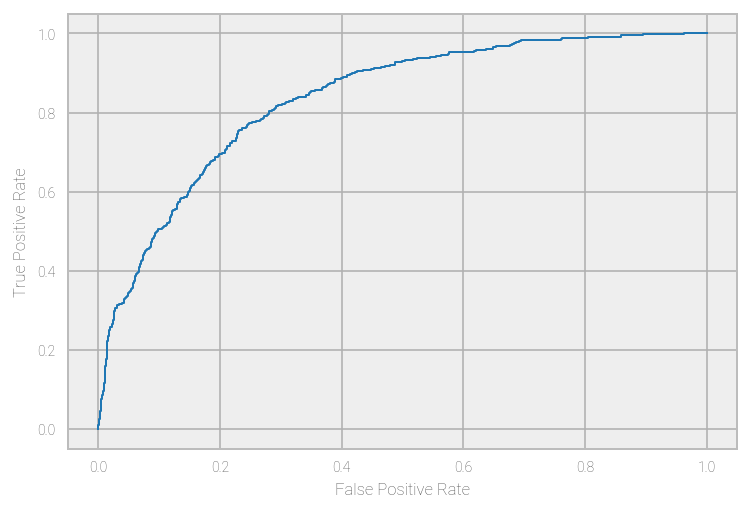

In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_probs = pipe.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic: ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
pyplot.plot(lr_fpr, lr_tpr, label='Logistic')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.show()

## Lime Explainer

https://github.com/marcotcr/lime

* training_data – numpy 2d array
* feature_names – list of names (strings) corresponding to the columns in the training data.
* categorical_features – list of indices (ints) corresponding to the categorical columns. Everything else will be considered continuous. Values in these columns MUST be integers.
* categorical_names – map from int to list of names, where categorical_names[x][y] represents the name of the yth value of column x.
* class_names – list of class names, ordered according to whatever the classifier is using. If not present, class names will be ‘0’, ‘1’, ...

In [7]:
from lime.lime_tabular import LimeTabularExplainer

data[labels.name + ' probability'] = pipe.predict_proba(X)[:, 1]

# List of length number of features, containing names of features in order
# in which they appear in X
feature_names = list(ce.columns_)

# List of indices of columns of X containing categorical features
categorical_features = list(ce.cat_columns_ix_.values())

# List of (index, [cat1, cat2...]) index-strings tuples, where each index
# is that of a categorical column in X, and the list of strings are the
# possible values it can take
categorical_names = {i: ce.classes_[c]
                     for c, i in ce.cat_columns_ix_.items()}
class_names = ['No ' + labels.name, labels.name]
explainer = LimeTabularExplainer(ce.transform(data),
                                 feature_names=feature_names,
                                 class_names=class_names,
                                 categorical_features=categorical_features,
                                 categorical_names=categorical_names)    



## Explaining a Single Instance


In [8]:
data.sample().T

id,2735
gender,Female
SeniorCitizen,0
Partner,No
Dependents,No
tenure,1
PhoneService,Yes
MultipleLines,No
InternetService,DSL
OnlineSecurity,No
OnlineBackup,No


In [9]:
exp = explainer.explain_instance(ce.transform(data.sample())[0],pipe.predict_proba)
for cols in exp.as_list():
    print(cols)

('tenure > 55.00', -0.27297815127035185)
('MonthlyCharges > 89.86', -0.2519715998578632)
('InternetService=Fiber optic', 0.20519813819442212)
('TotalCharges > 3794.74', 0.20012770706364574)
('Contract=Two year', -0.12942499693781434)
('StreamingTV=Yes', 0.08750957386806865)
('StreamingMovies=Yes', 0.07877081796378066)
('DeviceProtection=Yes', 0.04391397992693444)
('MultipleLines=No', -0.04151074998782685)
('OnlineBackup=Yes', 0.04113669773533294)


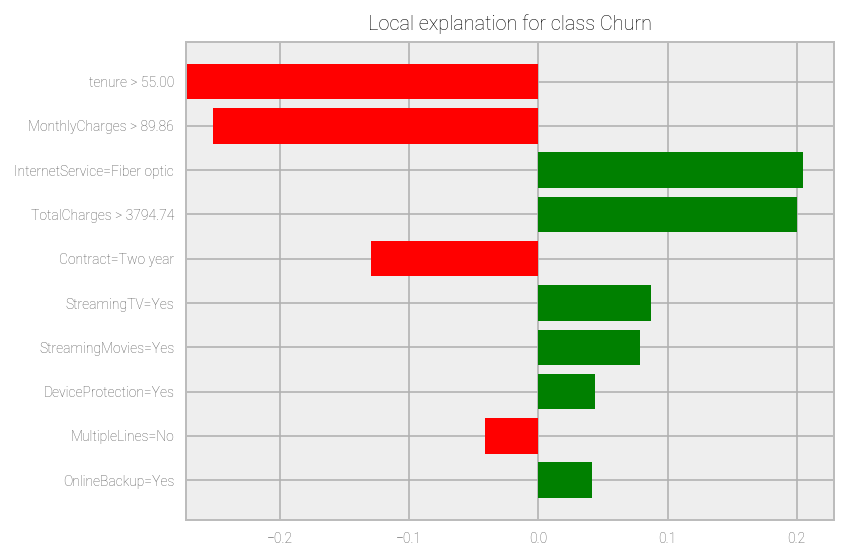

In [10]:
exp.as_pyplot_figure()
plt.tight_layout()

# ExplainedModel class
The ExplainedModel class is a handy wrapper that combines the CategoricalEncoder, the Pipeline and the Lime Explainer to make it easier to make and predict new features and is used in other parts of this project.

In [11]:
from churnexplainer import ExplainedModel
explainedmodel = ExplainedModel(data=data, labels=labels, model_name='telco_linear',
                                categoricalencoder=ce, pipeline=pipe,
                                explainer=explainer,data_dir=data_dir)
explainedmodel.save()